This notebook analyzes amazon review data. You can check the original data source.
[Data Source](https://www.kaggle.com/datafiniti/consumer-reviews-of-amazon-products?select=Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv)

# 1. **Read and Process Datasource**

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/chamsun-imoggo/udacity-ms/master/amazon_review/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-09-03T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,NaN,0,3,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-06-06T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,NaN,0,5,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...
2,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2018-04-20T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,NaN,0,4,https://reviews.bestbuy.com/3545/5442403/revie...,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,https://www.newegg.com/Product/Product.aspx%25...
3,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-11-02T17:33:31.000Z,NaN,2018-10-09T00:00:00Z,True,177283626.0,3,5,https://redsky.target.com/groot-domain-api/v1/...,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,https://www.newegg.com/Product/Product.aspx%25...
4,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2018-04-24T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,NaN,0,5,https://reviews.bestbuy.com/3545/5442403/revie...,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,https://www.newegg.com/Product/Product.aspx%25...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5000 non-null   object 
 1   dateAdded            5000 non-null   object 
 2   dateUpdated          5000 non-null   object 
 3   name                 5000 non-null   object 
 4   asins                5000 non-null   object 
 5   brand                5000 non-null   object 
 6   categories           5000 non-null   object 
 7   primaryCategories    5000 non-null   object 
 8   imageURLs            5000 non-null   object 
 9   keys                 5000 non-null   object 
 10  manufacturer         5000 non-null   object 
 11  manufacturerNumber   5000 non-null   object 
 12  reviews.date         5000 non-null   object 
 13  reviews.dateAdded    1052 non-null   object 
 14  reviews.dateSeen     5000 non-null   object 
 15  reviews.doRecommend  5000 non-null   b

In [4]:
df_review = df[['reviews.rating','reviews.text']].copy()

In [5]:
df_review.head()

,reviews.rating,reviews.text
0,3,I thought it would be as big as small paper bu...
1,5,This kindle is light and easy to use especiall...
2,4,Didnt know how much i'd use a kindle so went f...
3,5,I am 100 happy with my purchase. I caught it o...
4,5,Solid entry level Kindle. Great for kids. Gift...


In [6]:
df_review['sentiment'] = df_review['reviews.rating']>=4
df_review['sentiment'] = df_review['sentiment'].replace([True , False] , [1 , 0])

In [7]:
del df_review['reviews.rating']

In [8]:
df_review.rename(columns={'reviews.text':'text'}, inplace=True)

In [9]:
df_review.head()

,text,sentiment
0,I thought it would be as big as small paper bu...,0
1,This kindle is light and easy to use especiall...,1
2,Didnt know how much i'd use a kindle so went f...,1
3,I am 100 happy with my purchase. I caught it o...,1
4,Solid entry level Kindle. Great for kids. Gift...,1


In [10]:
df_review['sentiment'].value_counts()

1    4686
0     314
Name: sentiment, dtype: int64

In [11]:
import string
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

df_review['text']=df_review['text'].apply(lambda x : remove_punct(x))

In [12]:
from tqdm import tqdm
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop=set(stopwords.words('english'))
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

def create_corpus(df):
    corpus=[]
    for review in tqdm(df_review['text']):
        words=[word.lower() for word in word_tokenize(review) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
corpus=create_corpus(df_review)

100%|██████████| 5000/5000 [00:01<00:00, 4378.40it/s]


In [15]:
len(corpus)

5000

In [16]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

review_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

Using TensorFlow backend.


In [17]:
review_pad.shape

(5000, 50)

In [18]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 5824


In [19]:
train=review_pad[:4000]
test=review_pad[4000:]

In [20]:
train.shape

(4000, 50)

In [21]:
test.shape

(1000, 50)

In [22]:
def vectorize_sequences(sequences, dimension=5825):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  
    return results

train = vectorize_sequences(train)
test = vectorize_sequences(test)

In [23]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(5825,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [24]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [25]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [27]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(train,df_review['sentiment'][:4000].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (3400, 5825)
Shape of Validation  (600, 5825)


In [28]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history=model.fit(X_train,y_train,batch_size=512,epochs=20,validation_data=(X_test,y_test),verbose=2)

Train on 3400 samples, validate on 600 samples
Epoch 1/20
 - 0s - loss: 0.6504 - acc: 0.8047 - val_loss: 0.5875 - val_acc: 0.9433
Epoch 2/20
 - 0s - loss: 0.5524 - acc: 0.9371 - val_loss: 0.5132 - val_acc: 0.9433
Epoch 3/20
 - 0s - loss: 0.4826 - acc: 0.9371 - val_loss: 0.4569 - val_acc: 0.9433
Epoch 4/20
 - 0s - loss: 0.4279 - acc: 0.9371 - val_loss: 0.4116 - val_acc: 0.9433
Epoch 5/20
 - 0s - loss: 0.3832 - acc: 0.9371 - val_loss: 0.3756 - val_acc: 0.9433
Epoch 6/20
 - 0s - loss: 0.3460 - acc: 0.9371 - val_loss: 0.3457 - val_acc: 0.9433
Epoch 7/20
 - 0s - loss: 0.3147 - acc: 0.9371 - val_loss: 0.3218 - val_acc: 0.9433
Epoch 8/20
 - 0s - loss: 0.2882 - acc: 0.9371 - val_loss: 0.3021 - val_acc: 0.9433
Epoch 9/20
 - 0s - loss: 0.2659 - acc: 0.9371 - val_loss: 0.2866 - val_acc: 0.9433
Epoch 10/20
 - 0s - loss: 0.2463 - acc: 0.9371 - val_loss: 0.2734 - val_acc: 0.9433
Epoch 11/20
 - 0s - loss: 0.2279 - acc: 0.9376 - val_loss: 0.2625 - val_acc: 0.9433
Epoch 12/20
 - 0s - loss: 0.2105 - acc

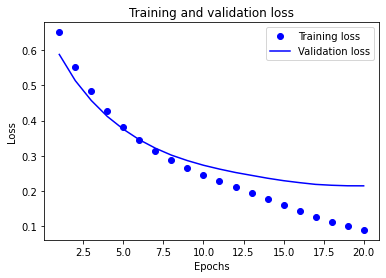

In [29]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# ‘bo’ means blue dots
plt.plot(epochs, loss, 'bo', label='Training loss')
# ‘b’ means blue line
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

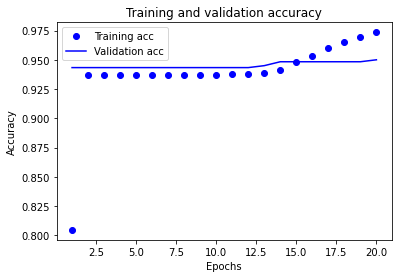

In [31]:
plt.clf()   # initialize graph
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [32]:
y_pred = model.predict(test)
y_pred=np.round(y_pred).astype(int).reshape(1000)

In [33]:
result = df_review['sentiment'][4000:].values == y_pred
unique, counts = np.unique(result, return_counts=True)

In [34]:
dict(zip(unique, counts))

{False: 49, True: 951}

In [ ]:
# train a new model with different epochs : 45

In [72]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(5825,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

model.fit(X_train,y_train,batch_size=512,epochs=45,validation_data=(X_test,y_test),verbose=2)

Train on 3400 samples, validate on 600 samples
Epoch 1/45
 - 0s - loss: 0.6292 - acc: 0.9312 - val_loss: 0.5646 - val_acc: 0.9433
Epoch 2/45
 - 0s - loss: 0.5258 - acc: 0.9371 - val_loss: 0.4841 - val_acc: 0.9433
Epoch 3/45
 - 0s - loss: 0.4493 - acc: 0.9371 - val_loss: 0.4223 - val_acc: 0.9433
Epoch 4/45
 - 0s - loss: 0.3896 - acc: 0.9371 - val_loss: 0.3755 - val_acc: 0.9433
Epoch 5/45
 - 0s - loss: 0.3424 - acc: 0.9371 - val_loss: 0.3384 - val_acc: 0.9433
Epoch 6/45
 - 0s - loss: 0.3045 - acc: 0.9371 - val_loss: 0.3111 - val_acc: 0.9433
Epoch 7/45
 - 0s - loss: 0.2746 - acc: 0.9371 - val_loss: 0.2902 - val_acc: 0.9433
Epoch 8/45
 - 0s - loss: 0.2506 - acc: 0.9371 - val_loss: 0.2752 - val_acc: 0.9433
Epoch 9/45
 - 0s - loss: 0.2314 - acc: 0.9371 - val_loss: 0.2632 - val_acc: 0.9433
Epoch 10/45
 - 0s - loss: 0.2140 - acc: 0.9371 - val_loss: 0.2535 - val_acc: 0.9433
Epoch 11/45
 - 0s - loss: 0.1984 - acc: 0.9371 - val_loss: 0.2451 - val_acc: 0.9433
Epoch 12/45
 - 0s - loss: 0.1834 - acc

In [73]:
y_pred = model.predict(test)
y_pred=np.round(y_pred).astype(int).reshape(1000)
result = df_review['sentiment'][4000:].values == y_pred
unique, counts = np.unique(result, return_counts=True)

In [74]:
dict(zip(unique, counts))

{False: 42, True: 958}